Author:  Raphael Cousin

Project: https://github.com/racousin/algorithms_basics_python

# Theory

__Context:__

* Data : $X \in \mathbb{R}^d$ 


* Classes : $Y \in \{-1,1\}$

* Classifier :
$g^*(x) = \left\{\begin{array}{ll}1 & if\quad\mathbb{P}(Y = 1 | X = x) >\mathbb{P}(Y = -1 | X = x) \\-1 & else\end{array}\right.$

* sample size: $n$

* feature size : $p$

__Rademacher complexity:__

$R(\mathcal{C}(X)) = \frac{1}{n} \mathbb{E}_\sigma\left[sup_{g\in \mathcal{C}} \sum_{i=1}^{n}\sigma_i g(X_i)\right]$

where $\sigma \quad iid$ from Rademacher distribution

__ADABOOST:__

exponential loss $\varphi : x \mapsto e^{-Y_ix}$

* initialisation:

classifier number $T\in \mathbb{N}$

points weight $D_1(i) = \frac{1}{n} \forall i \in [1,n]$

$f_0 = 0$

* iteration for t of 1 to n:

choice of classifier $g_t \in \mathcal{C}$ wich as $\epsilon_t = \sum_{i=1}^n D_t(i) \mathbb{1}_{g_t(X_i) \neq Y_i} \leq small$

classifier weight $w_t \in argmin_{w \in \mathbb{R}}\frac{1}{n}\sum_{i=1}^{n}\varphi_i\left(f_{t-1}(X_i) + wg_t(X_i)\right)$

normalization $Z_t = \sum_{i = 1}^{n} D_t(i)\varphi(-w_tg_t(X_i))$

$D_{t + 1}(i) = \frac{D_t(i)\varphi(-w_tg_t(X_i))}{Z_t} \forall i \in [1, n]$

* adaboost classifier

$g_n^T = sign(f_T)$

__Hypothesis:__

$\exists \gamma > 0 \quad \forall t \in [1,T] \quad \epsilon_t \leq \frac{1}{2} - \gamma \quad ps$

__Results:__

$\epsilon_t \leq e^{-2\gamma^2T}$


$\mathbb{P}(Y\neq g_n^T(X)) \leq \left((1 - 4\gamma^2)(\frac{1 + 2\gamma}{1 - 2 \gamma})^\gamma\right)^{T/2} + \frac{4}{\gamma} R(\mathcal{C}(X)) + \sqrt{\frac{-log(\gamma)}{2n}}$

# Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.discriminant_analysis import LinearClassifierMixin
from sklearn.tree import DecisionTreeClassifier

# Example

In [2]:
#2d plot function
def plot_2dX_Y(X, Y, ax=plt):
    X1 = X[Y == 1]
    X2 = X[Y == -1]
    ax.plot(X1[:, 0], X1[:, 1], ">", label="Class 1")
    ax.plot(X2[:, 0], X2[:, 1], "d", label="Class 2")

In [3]:
# plot border from clf
def plot_border(clf, data=None, num=500, label=None,ax=plt):
    """
        Plot the frontiere f(x)=0 of the classifier clf within the same range as the one
        of the data.
        Input:
            clf: binary classifier with a method decision_function
            data: input data (X)
            num: discretization parameter
    """
    xmin, ymin = data.min(axis=0)
    xmax, ymax = data.max(axis=0)
    x, y = np.meshgrid(np.linspace(xmin, xmax, num), np.linspace(ymin, ymax))
    z = np.fabs(clf.decision_function(np.c_[x.ravel(), y.ravel()])).reshape(x.shape)
    zmin, zmax = z.min(), z.max()
    ind = np.where((z-zmin)/(zmax-zmin) < 0.001)
    ind_sort = np.argsort(y[ind])
    ax.plot(x[ind][ind_sort], y[ind][ind_sort], label=label, linewidth=2)

In [4]:
from matplotlib import cm

def map_regions(clf, data=None, num=50, ax = plt):
    """
        Map the regions f(x)=1…K of the classifier clf within the same range as the one
        of the data.
        Input:
            clf: classifier with a method predict
            data: input data (X)
            num: discretization parameter
    """
    xmin, ymin = data.min(axis=0)
    xmax, ymax = data.max(axis=0)
    x, y = np.meshgrid(np.linspace(xmin, xmax, num), np.linspace(ymin, ymax))
    z = clf.predict(np.c_[x.ravel(), y.ravel()]).reshape(x.shape)
    zmin, zmax = z.min(), z.max()
    ax.imshow(z, origin='lower', interpolation="nearest",
               extent=[xmin, xmax, ymin, ymax], cmap=cm.coolwarm,
              alpha=0.3)

In [5]:
def get_metrics(clf,X,Y):
    """
        Input:
            clf: binary classifier with a method predict_function
            data: (X)
            classes: (Y) consider that Y=1 is 'yes class' and Y=-1 is 'No class'
    """
    pred = clf.predict(X)
    TP = ((pred == 1) & (Y == 1)).sum()
    TN = ((pred == -1) & (Y == -1)).sum()
    FP = ((pred == 1) & (Y == -1)).sum()
    FN = ((pred == -1) & (Y == 1)).sum()
    accuracy = (TP + TN) / (TP + TN + FN + FP)
    prec = TP/ (TP + FP)
    recall = TP / (TP + FN)
    F1Score = 2*(recall * prec) / (recall + prec)
    print('True Positive:',TP)
    print('True Negative:',TN)
    print('False Positive:',FP)
    print('False Negative:',FN)
    print('Accuracy:', accuracy)
    print('Precision:', prec)
    print('Recall:', recall)
    print('F1 Score:', F1Score)

In [6]:
class AdaBoost(BaseEstimator, LinearClassifierMixin):
    def __init__(self, T = 1):
        self.g = None
        self.clf = None
        self.d = None
        self.w = None
        self.z = None
        self.f = None
        self.T = T;
        
    def fit(self, X, Y):
        eps = lambda i, x, g: (self.d * (g(i, x) != Y)).sum()
        self.d = np.ones(X.shape[0]) / X.shape[0]
        self.g = [0] * self.T
        self.clf = [0] * self.T
        self.w = [0] * self.T
        for i in range(self.T):
            self.clf[i] = DecisionTreeClassifier(max_depth = 1, random_state = 1)
            self.clf[i].fit(X, Y,sample_weight = self.d)
            self.g[i] = lambda i,x : self.clf[i].predict(x)
            self.w[i] = 0.5 *np.log((1-eps(i, X, self.g[i])) / eps(i, X, self.g[i]))
            self.z = 2 * (eps(i, X, self.g[i])*(1 - eps(i, X, self.g[i]))) ** 0.5
            self.d = self.d * np.exp(-self.w[i] * Y * self.g[i](i,X)) / self.z
        def f(x):
            res = 0;
            for i in range(self.T):
                res += self.w[i] * self.g[i](i, x)
            return res;
        self.f = f;
        return self
        
    def decision_function(self, X):
        return self.f(X)

    def predict(self, X):
        return np.sign(self.decision_function(X))

In [7]:
#generate data
p = 2;
n = 1000;
mu1 = np.random.randn(p) * 20
mu2 = np.random.randn(p) * 5
A = np.random.rand(p,p)
sigma1 = np.dot(A,A.transpose()) * 1000
A = np.random.rand(p,p)
sigma2 = np.dot(A,A.transpose()) * 1000

n1 = np.random.randint(int(n*0.1),int(n*0.9));
n2 = n - n1;
X1 = np.r_[np.random.multivariate_normal(size=int(n1 / 2),mean=mu1,cov=sigma1),np.random.multivariate_normal(size=int(n1 / 2),mean=-mu1,cov=sigma1)]
X2 = np.random.multivariate_normal(size=n2,mean=mu2,cov=sigma2)

Y1 = np.ones(n1)
Y2 = -np.ones(n2)
X = np.r_[X1, X2]
Y = np.r_[np.ones(X1.shape[0]), -np.ones(X2.shape[0])]

In [8]:
#train set and test set
data = np.c_[X,Y]
np.random.shuffle(data)
X_train = data[:int(n *0.9),0:p]
Y_train = data[:int(n *0.9),p]
X_test = data[int(n *0.9):,0:p]
Y_test = data[int(n *0.9):,p]

In [9]:
#compute model
ada = AdaBoost(T=120)
ada.fit(X_train, Y_train)

AdaBoost(T=120)

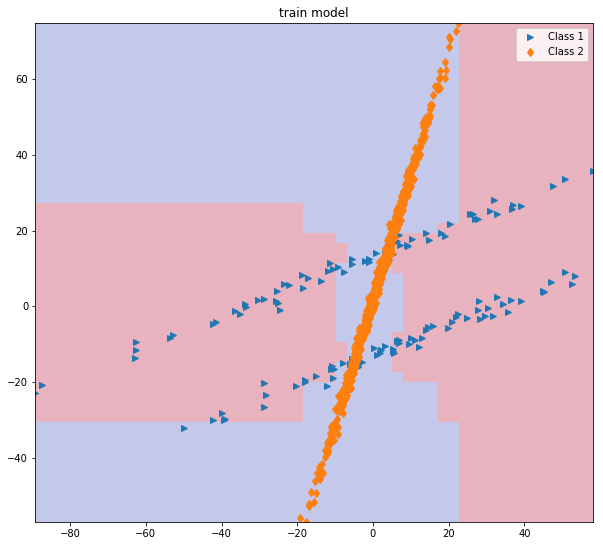

In [10]:
#plot train
fig, ax = plt.subplots(figsize=(10,10))
plot_2dX_Y(X_train, Y_train,ax)
#plot_border(ada, X_train,ax = ax,label='mine')
map_regions(ada, X_train,ax = ax)
ax.set_title('train model')
ax.legend(loc="best");

In [11]:
#metrics train
get_metrics(ada, X_train, Y_train)

True Positive: 108
True Negative: 769
False Positive: 0
False Negative: 23
Accuracy: 0.9744444444444444
Precision: 1.0
Recall: 0.8244274809160306
F1 Score: 0.9037656903765691


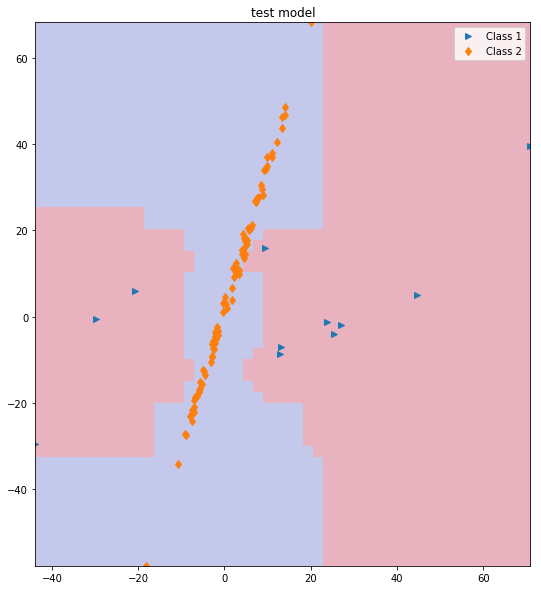

In [12]:
#plot test
fig, ax = plt.subplots(figsize=(10,10))
plot_2dX_Y(X_test, Y_test,ax)
map_regions(ada, X_test,ax = ax)
ax.set_title('test model')
ax.legend(loc="best");

In [13]:
#metrics test
get_metrics(ada, X_test, Y_test)

True Positive: 11
True Negative: 89
False Positive: 0
False Negative: 0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


# References

In [14]:
from sklearn.ensemble import AdaBoostClassifier

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
